In [76]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import log_loss

TRAINING_DATA_FOLDER = 'Training_Images'
TESTING_DATA_FOLDER = 'Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))


In [77]:
train_list_real
train_list_fake

['acpvctzdde_185_0.jpg',
 'aczofflgti_247_0.jpg',
 'ajwpjhrbcv_18_0.jpg',
 'ajwpjhrbcv_32_0.jpg',
 'ajwpjhrbcv_101_0.jpg',
 'ajwpjhrbcv_143_0.jpg',
 'ajwpjhrbcv_215_0.jpg',
 'akzoyfpvfd_76_0.jpg',
 'akzoyfpvfd_83_0.jpg',
 'akzoyfpvfd_105_0.jpg',
 'akzoyfpvfd_243_0.jpg',
 'akzoyfpvfd_299_0.jpg',
 'alpkghdgrv_46_0.jpg',
 'alpkghdgrv_79_0.jpg',
 'alpkghdgrv_212_0.jpg',
 'alpkghdgrv_222_0.jpg',
 'alpkghdgrv_252_0.jpg',
 'amczvybpav_264_0.jpg',
 'anglrrmdnf_15_0.jpg',
 'anglrrmdnf_116_0.jpg',
 'anglrrmdnf_119_0.jpg',
 'anglrrmdnf_165_0.jpg',
 'anglrrmdnf_179_0.jpg',
 'anunyoghdg_228_0.jpg',
 'aoallgteyc_107_0.jpg',
 'aqvpagjeub_6_0.jpg',
 'aqvpagjeub_95_0.jpg',
 'aqvpagjeub_209_0.jpg',
 'aqvpagjeub_214_0.jpg',
 'aqvpagjeub_245_0.jpg',
 'arfqjhbpax_65_0.jpg',
 'arfqjhbpax_67_0.jpg',
 'arfqjhbpax_94_0.jpg',
 'arfqjhbpax_136_0.jpg',
 'arfqjhbpax_293_0.jpg',
 'asmvgulrof_65_0.jpg',
 'asmvgulrof_125_0.jpg',
 'asmvgulrof_148_0.jpg',
 'asmvgulrof_195_0.jpg',
 'asmvgulrof_282_0.jpg',
 'auzofkvxmb_1

In [78]:
def show_train_img(Folder):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    ten_random_samples = pd.Series(os.listdir(os.path.join(TRAINING_DATA_FOLDER, Folder))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(TRAINING_DATA_FOLDER, Folder, image)
        img = cv.imread(final_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()


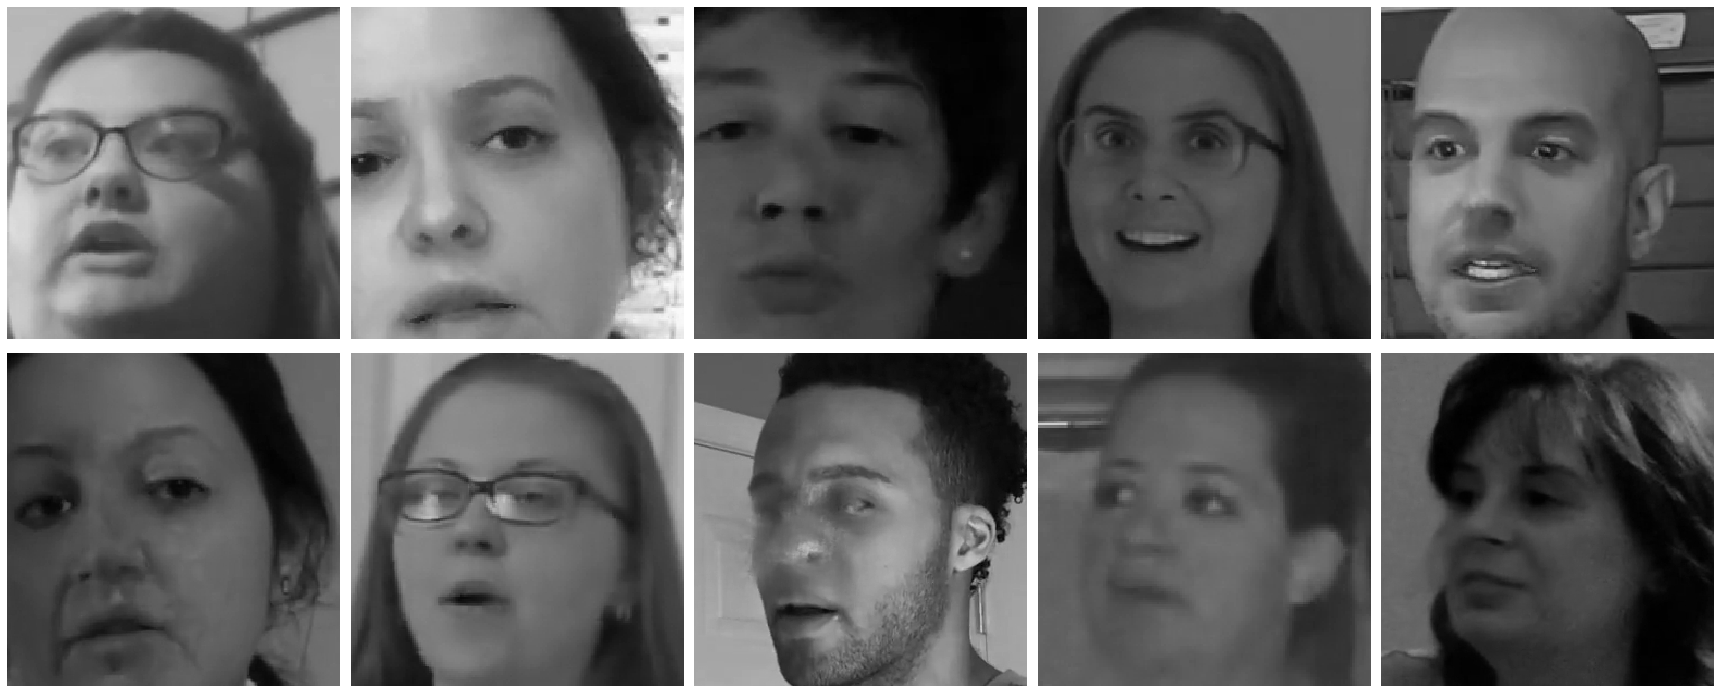

In [79]:
show_train_img(FAKE_FOLDER)

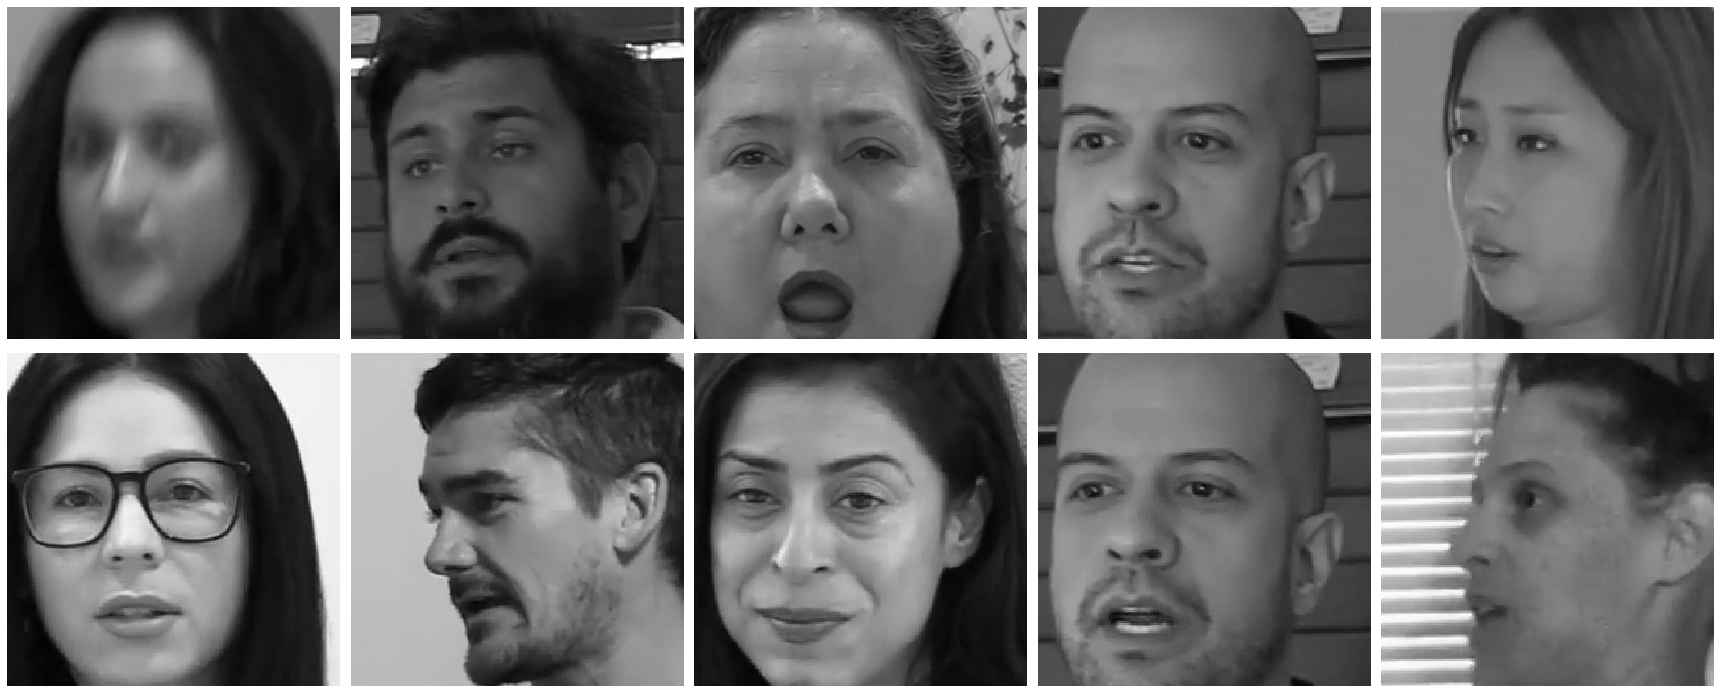

In [80]:
show_train_img(REAL_FOLDER)

In [81]:
import tensorflow as tf 
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [82]:
#Image batch generator

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_batches = train_gen.flow_from_directory(TRAINING_DATA_FOLDER,
                                              shuffle=True,
                                              subset="training",
                                              target_size=(128,128), 
                                              batch_size=10,
                                              color_mode="grayscale", 
                                              class_mode='binary')

validation_batches = train_gen.flow_from_directory(TRAINING_DATA_FOLDER,
                                              shuffle=True,
                                              subset="validation",
                                              target_size=(128,128), 
                                              batch_size=10,
                                              color_mode="grayscale", 
                                              class_mode='binary')

testing_batches = train_gen.flow_from_directory(TESTING_DATA_FOLDER,
                                              shuffle=True,
                                              target_size=(128,128), 
                                              batch_size=10,
                                              color_mode="grayscale", 
                                              class_mode='binary')

Found 1747 images belonging to 2 classes.
Found 436 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [83]:
#Split into X,Y

x , y = [] , []
for i in range(150):
    a , b = train_batches.next()
    x.extend(a) 
    y.extend(b)
    
x = np.asarray(x)
y = np.asarray(y)

x_valid , y_valid = [] , []
for i in range(30):
    a , b = validation_batches.next()
    x_valid.extend(a) 
    y_valid.extend(b)
    
x_valid = np.asarray(x_valid)
y_valid = np.asarray(y_valid)

x_test , y_test = [] , []
for i in range(6):
    a , b = testing_batches.next()
    x_test.extend(a) 
    y_test.extend(b)
    
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [84]:
# Build the autoencoder

model = tensorflow.keras.Sequential()
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(128,128,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)       

In [85]:
#Fit input and output with same image to train the latent space

model.fit(x,x, epochs=5, batch_size=64)

Epoch 1/5
24/24 [==============================] - 128s 5s/step - loss: 0.0424
Epoch 2/5
24/24 [==============================] - 128s 5s/step - loss: 0.0093
Epoch 3/5
24/24 [==============================] - 140s 6s/step - loss: 0.0062
Epoch 4/5
24/24 [==============================] - 135s 6s/step - loss: 0.0045
Epoch 5/5
24/24 [==============================] - 134s 6s/step - loss: 0.0036


In [86]:
model.save('E:/cv/dfdc/model')

INFO:tensorflow:Assets written to: E:/cv/dfdc/model\assets


In [87]:
#Extract encoder

encoder = K.function([model.layers[0].input], [model.layers[4].output])

In [88]:
#Build classifier model with latent space feature

model2 = tensorflow.keras.Sequential()
model2.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32,32,32)))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2,2), padding='same'))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)

model2.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

#Freezing the laten space layer
model2.layers[0].trainable=False
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8193      
Total params: 17,569
Trainable params: 8,257
Non-trainable params: 9,312
_________________________________________________________________


In [89]:
#Copy weightage from autoencoder latent space layer to classifier latent space layer

model2.layers[0].set_weights(model.layers[6].get_weights())

In [90]:
#Passing image data to encoder input layer and classifier input layer

encoder_output = encoder(x)[0]
model2.fit(encoder_output,y, epochs=30, batch_size=32)

Epoch 1/30
47/47 [==============================] - 5s 77ms/step - loss: 0.6901 - accuracy: 0.5545
Epoch 2/30
47/47 [==============================] - 4s 78ms/step - loss: 0.6181 - accuracy: 0.6626
Epoch 3/30
47/47 [==============================] - 4s 88ms/step - loss: 0.5887 - accuracy: 0.6950
Epoch 4/30
47/47 [==============================] - 4s 78ms/step - loss: 0.5505 - accuracy: 0.7249
Epoch 5/30
47/47 [==============================] - 4s 79ms/step - loss: 0.5296 - accuracy: 0.7427
Epoch 6/30
47/47 [==============================] - 4s 77ms/step - loss: 0.5303 - accuracy: 0.7303
Epoch 7/30
47/47 [==============================] - 4s 93ms/step - loss: 0.5084 - accuracy: 0.7681 1s - loss:
Epoch 8/30
47/47 [==============================] - 4s 77ms/step - loss: 0.4873 - accuracy: 0.7771
Epoch 9/30
47/47 [==============================] - 4s 78ms/step - loss: 0.4666 - accuracy: 0.7916
Epoch 10/30
47/47 [==============================] - 4s 79ms/step - loss: 0.4616 - accuracy: 0.795

In [115]:
#Testing with validation batch

encoder_valid_output = encoder(x_valid)[0]
y_predict = model2.predict(encoder_valid_output)
y_predict_class = np.round(y_predict, 0)
f1_score(y_valid, y_predict_class)

0.6962962962962963

In [116]:
#LogLoss calculation for DFDC benchmark

log_loss(y_valid, y_predict) 

0.5901565067609772

In [117]:
confusion_matrix(y_valid, y_predict_class)

array([[124,  35],
       [ 47,  94]], dtype=int64)

In [118]:
#Testing with totally unseen video frame

encoder_test_output = encoder(x_test)[0]
y_predict = model2.predict(encoder_test_output)
y_predict_class = np.round(y_predict, 0)
f1_score(y_test, y_predict_class)

0.7096774193548386

In [119]:
log_loss(y_test, y_predict) 

0.5668700272915885

In [120]:
train_batches.class_indices

{'FAKE': 0, 'REAL': 1}